In [1]:
import pandas as pd 
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import selenium
import datetime
import time 

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# Webscraping historical stock data

In [2]:
def download_data(stock_code: str) -> pd.DataFrame:
    driver = webdriver.Chrome()
    driver.get("https://cafef.vn/du-lieu/Lich-su-giao-dich-vnindex-1.chn")

    # SEARCH CODE
    code_search_bar = driver.find_element(by=By.ID, value="ContentPlaceHolder1_ctl00_acp_inp_disclosure")
    code_search_bar.clear()
    code_search_bar.send_keys(stock_code)

    # SEARCH DATE RANGE
    date_search_bar = driver.find_element(by=By.ID, value="date-inp-disclosure")
    date_search_bar.clear()
    date_search_bar.send_keys(f'21/11/2006 - {datetime.date.today().strftime("%d/%m/%Y")}')

    drop_buttons = driver.find_element(by=By.CLASS_NAME, value="drp-buttons")
    for button in drop_buttons.find_elements(by=By.TAG_NAME, value="button"):
        if button.text == "Chọn":
            button.click()

    # LOAD QUERY
    view_button = driver.find_element(by=By.ID, value="owner-find")
    view_button.click()

    time.sleep(3) # wait for query to load

    page_navigator = driver.find_element(by=By.ID, value="wraper-content-paging")
    total_pages = int(page_navigator.find_elements(by=By.TAG_NAME, value="div")[-1].text)

    data = []
    for _ in range(1, total_pages + 1):
            # Scrape data
            data_table = driver.find_element(by=By.ID, value="render-table-owner")
            for row in data_table.find_elements(by=By.TAG_NAME, value="tr"):
                row_data = []
                for value in row.find_elements(by=By.TAG_NAME, value="td"):
                    row_data.append(value.text)
                data.append(row_data)
            
            # Go to next page
            next_button = driver.find_element(by=By.ID, value="paging-right")
            next_button.click()
            time.sleep(3) # wait for next page to load

    driver.quit()
    data = pd.DataFrame(data=data, columns=["Date", "Close", "Adjusted", "Change", "Volume1", "Value1", "Volume2", "Value2", "Open", "High", "Low"])
    return data

In [ ]:
# Store data
ACB_data = download_data("ACB")
VNINDEX_data = download_data("VNINDEX")
ACB_data.to_csv(path_or_buf=r"C:\Users\X1 Carbon\Desktop\ACB_data.csv", index=False)
VNINDEX_data.to_csv(path_or_buf=r"C:\Users\X1 Carbon\Desktop\VNINDEX_data.csv", index=False)

# Data Preprocessing

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
ACB_data = pd.read_csv(r"C:\Users\X1 Carbon\Desktop\ACB_data.csv")
VNINDEX_data = pd.read_csv(r"C:\Users\X1 Carbon\Desktop\VNINDEX_data.csv")

In [5]:
stock_data = ACB_data.join(other=VNINDEX_data.set_index(keys="Date"), on="Date", how="inner", lsuffix="_ACB", rsuffix="_VNINDEX", validate="1:1")
stock_data.index = stock_data.index[::-1] + 1 # Reverse index to make it easier, + 1 to denote as nth date starting from 1st date instead of 0th date
stock_data.head()

,Date,Close_ACB,Adjusted_ACB,Change_ACB,Volume1_ACB,Value1_ACB,Volume2_ACB,Value2_ACB,Open_ACB,High_ACB,Low_ACB,Close_VNINDEX,Adjusted_VNINDEX,Change_VNINDEX,Volume1_VNINDEX,Value1_VNINDEX,Volume2_VNINDEX,Value2_VNINDEX,Open_VNINDEX,High_VNINDEX,Low_VNINDEX
4753,25/12/2025,24.0,24.0,-0.3(-1.23 %),"7,250,600",176.04,0,0,24.30,24.60,24.00,1742.85,"1,742.85",-39.97(-2.24 %),"633,673,500","20,443.85","170,602,635","4,831.95","1,779.19","1,805.93","1,742.69"
4752,24/12/2025,24.3,24.3,0.1(0.41 %),"8,709,200",211.29,0,0,24.15,24.45,23.95,1782.82,"1,782.82",10.67(0.60 %),"685,288,200","20,932.13","104,025,839","3,342.99","1,782.71","1,784.98","1,753.65"
4751,23/12/2025,24.2,24.2,-0.1(-0.41 %),"8,578,300",207.85,"90,000",2.25,24.45,24.60,23.95,1772.15,"1,772.15",21.12(1.21 %),"731,625,700","22,500.32","106,819,512","2,856.80","1,765","1,778.18","1,763.52"
4750,22/12/2025,24.3,24.3,0.4(1.67 %),"10,013,100",242.28,0,0,24.00,24.45,23.90,1751.03,"1,751.03",46.72(2.74 %),"754,739,700","21,070.30","193,896,808","8,237.53","1,719.86","1,751.16","1,712.48"
4749,19/12/2025,23.9,23.9,0.05(0.21 %),"3,538,700",84.68,"1,271,000",30.29,23.90,24.05,23.85,1704.31,"1,704.31",27.33(1.63 %),"660,124,800","20,922.73","108,796,230","2,946.16","1,678.72","1,705.76","1,677.67"


In [6]:
# Extract stock price percentage change and format it
stock_data["Change_ACB (%)"] = stock_data["Change_ACB"].str.split(pat="(", expand=True)[1]
stock_data["Change_ACB (%)"] = stock_data["Change_ACB (%)"].str.rstrip(" %)")

stock_data["Change_VNINDEX (%)"] = stock_data["Change_VNINDEX"].str.split(pat="(", expand=True)[1]
stock_data["Change_VNINDEX (%)"] = stock_data["Change_VNINDEX (%)"].str.rstrip(" %)")

# Remove comma thousand separator in columns to convert to float
stock_data = stock_data.astype(dtype="str")
for column in stock_data.columns.drop("Date"):
    stock_data[column] = stock_data[column].str.replace(pat=",", repl="")

# Convert columns to the correct datatype
stock_data.drop(columns=["Change_ACB", "Change_VNINDEX"], inplace=True)
stock_data[stock_data.columns.drop("Date")] = stock_data[stock_data.columns.drop("Date")].astype(dtype="float64")

# Group the Volume column
stock_data["Volume_ACB"] = stock_data["Volume1_ACB"] + stock_data["Volume2_ACB"]

# Remove redundant columns
stock_data.drop(columns=["Adjusted_VNINDEX", "Volume1_ACB", "Volume2_ACB", "Volume1_VNINDEX", "Volume2_VNINDEX", 
                         "Value1_ACB", "Value2_ACB", "Value1_VNINDEX", "Value2_VNINDEX", "Open_VNINDEX", "High_VNINDEX", "Low_VNINDEX"], inplace=True)

stock_data.head()

,Date,Close_ACB,Adjusted_ACB,Open_ACB,High_ACB,Low_ACB,Close_VNINDEX,Change_ACB (%),Change_VNINDEX (%),Volume_ACB
4753,25/12/2025,24.0,24.0,24.30,24.60,24.00,1742.85,-1.23,-2.24,7250600.0
4752,24/12/2025,24.3,24.3,24.15,24.45,23.95,1782.82,0.41,0.60,8709200.0
4751,23/12/2025,24.2,24.2,24.45,24.60,23.95,1772.15,-0.41,1.21,8668300.0
4750,22/12/2025,24.3,24.3,24.00,24.45,23.90,1751.03,1.67,2.74,10013100.0
4749,19/12/2025,23.9,23.9,23.90,24.05,23.85,1704.31,0.21,1.63,4809700.0


# Feature Engineering

In [7]:
# Create Moving Averages (SMA and EMA), Bollinger Bands and MACD indicators
def sma(period: int, value: str) -> list:
    price_values = stock_data[value].values
    sma_values = []

    for i in range(len(price_values) - period + 1): # Limit of the window of length 'period'
        window = price_values[i : i + period]
        sma_values.append(np.round(np.mean(window), 4))
    
    sma_values = sma_values + [-1] * (len(price_values) - len(sma_values)) # Pad the SMA value list with -1 so that it has the same size as the price column to concat later
    return sma_values

def ema(period: int, value: str, sma_col_name: str, smoothing: int = 2) -> list:
    price_values = stock_data[value].values
    sma_values = stock_data[sma_col_name].values
    ema_values = [-1] * len(sma_values) # Initialize EMA value list
    multiplier = smoothing / (1 + period)

    for i in range(len(sma_values) - period - 1, -1, -1):
        if (i == len(sma_values) - period - 1): # Get starting EMA value, which is the SMA value of the previous day
            ema_values[i] = sma_values[i + 1]
        else:
            ema_values[i] = np.round(price_values[i] * multiplier + ema_values[i + 1] * (1 - multiplier), 4)
    
    return ema_values

def bb(value: str, period: int = 20) -> list:
    price_values = stock_data[value].values
    upper_bb = []
    lower_bb = []

    for i in range(len(price_values) - period + 1):
        window = price_values[i : i + period]
        std = np.std(window)
        sma = np.mean(window)
        upper_bb.append(np.round(sma + std * 2, 2))
        lower_bb.append(np.round(sma - std * 2, 2))
    
    upper_bb = upper_bb + [-1] * (len(price_values) - len(upper_bb))
    lower_bb = lower_bb + [-1] * (len(price_values) - len(lower_bb))

    return [upper_bb, lower_bb]

stock_data["SMA 12 (Close)"] = sma(period=12, value="Close_ACB")
stock_data["SMA 26 (Close)"] = sma(period=26, value="Close_ACB")
stock_data["SMA 200 (Close)"] = sma(period=200, value="Close_ACB")
stock_data["SMA 200 (High)"] = sma(period=200, value="High_ACB")
stock_data["SMA 200 (Low)"] = sma(period=200, value="Low_ACB")

stock_data["EMA 12 (Close)"] = ema(period=12, value="Close_ACB", sma_col_name="SMA 12 (Close)")
stock_data["EMA 26 (Close)"] = ema(period=26, value="Close_ACB", sma_col_name="SMA 26 (Close)")
stock_data["EMA 200 (Close)"] = ema(period=200, value="Close_ACB", sma_col_name="SMA 200 (Close)")
stock_data["EMA 200 (High)"] = ema(period=200, value="High_ACB", sma_col_name="SMA 200 (High)")
stock_data["EMA 200 (Low)"] = ema(period=200, value="Low_ACB", sma_col_name="SMA 200 (Low)")

stock_data["MACD"] = stock_data["EMA 12 (Close)"] - stock_data["EMA 26 (Close)"]
stock_data["SMA 9 (MACD)"] = sma(period=9, value="MACD")
stock_data["Signal"] = ema(period=9, value="MACD", sma_col_name="SMA 9 (MACD)") # Signal line is nine-period EMA OF THE MACD line, NOT the price
stock_data["Histogram"] = stock_data["MACD"] - stock_data["Signal"]

histo_values = stock_data["Histogram"].values
cross_over_status = []
for i in range(len(histo_values) - 1):
    if (histo_values[i] > 0 and histo_values[i + 1] <= 0) or (histo_values[i] < 0 and histo_values[i + 1] >= 0):
        cross_over_status.append(1)
    else:
        cross_over_status.append(0)
        
cross_over_status.append(0) # Append one last 0 since the earliest date has no previous date to compare to
stock_data["MACD Crossover"] = cross_over_status

stock_data["Upper BB"], stock_data["Lower BB"] = bb(value="Close_ACB")
stock_data["Outside BB"] = ((stock_data["Close_ACB"] < stock_data["Lower BB"]) | (stock_data["Close_ACB"] > stock_data["Upper BB"])).astype(dtype=int)

# Create label column
stock_data["Trend"] = stock_data["Change_ACB (%)"].apply(lambda x: 1 if x >= 0 else -1)

# Remove SMA columns and EMA 12/26 columns since those are only needed for the calculations of other EMA and MACD columns
stock_data.drop(columns=["EMA 12 (Close)", "EMA 26 (Close)", "SMA 12 (Close)", "SMA 26 (Close)", "SMA 200 (Close)", 
                         "SMA 200 (High)", "SMA 200 (Low)", "SMA 9 (MACD)"], inplace=True)

# Round EMA, MACD, Signal, and Historgram columns to 2 d.p (did not do it earlier to avoid rounding errors)
col_to_round = ["EMA 200 (Close)", "EMA 200 (High)", "EMA 200 (Low)", "MACD", "Signal", "Histogram"]
stock_data[col_to_round] = stock_data[col_to_round].apply(lambda x: round(x, 2)) 

# Shift data by 1 date before since we use YESTERDAY's data -> TODAY's stock trend
stock_data[stock_data.columns.drop(labels=["Date", "Trend"])] = stock_data[stock_data.columns.drop(labels=["Date", "Trend"])].shift(-1)

stock_data.head(10)

,Date,Close_ACB,Adjusted_ACB,Open_ACB,High_ACB,Low_ACB,Close_VNINDEX,Change_ACB (%),Change_VNINDEX (%),Volume_ACB,EMA 200 (Close),EMA 200 (High),EMA 200 (Low),MACD,Signal,Histogram,MACD Crossover,Upper BB,Lower BB,Outside BB,Trend
4753,25/12/2025,24.30,24.30,24.15,24.45,23.95,1782.82,0.41,0.60,8709200.0,24.74,25.01,24.54,-0.18,-0.26,0.08,0.0,24.72,23.50,0.0,-1
4752,24/12/2025,24.20,24.20,24.45,24.60,23.95,1772.15,-0.41,1.21,8668300.0,24.74,25.02,24.55,-0.22,-0.28,0.06,0.0,24.71,23.50,0.0,1
4751,23/12/2025,24.30,24.30,24.00,24.45,23.90,1751.03,1.67,2.74,10013100.0,24.75,25.02,24.56,-0.25,-0.30,0.05,0.0,24.71,23.50,0.0,-1
4750,22/12/2025,23.90,23.90,23.90,24.05,23.85,1704.31,0.21,1.63,4809700.0,24.75,25.03,24.56,-0.29,-0.31,0.02,0.0,24.76,23.48,0.0,1
4749,19/12/2025,23.85,23.85,24.00,24.00,23.80,1676.98,-0.62,0.20,5558000.0,24.76,25.04,24.57,-0.31,-0.31,0.01,1.0,24.83,23.49,0.0,1
4748,18/12/2025,24.00,24.00,24.05,24.15,23.90,1673.66,0.00,-0.33,14406100.0,24.77,25.05,24.58,-0.32,-0.32,-0.00,0.0,24.92,23.49,0.0,-1
4747,17/12/2025,24.00,24.00,23.55,24.80,23.45,1679.18,1.91,2.02,9830200.0,24.78,25.06,24.58,-0.34,-0.32,-0.02,0.0,25.02,23.49,0.0,1
4746,16/12/2025,23.55,23.55,23.50,23.60,23.45,1646.01,0.21,-0.05,11356100.0,24.79,25.06,24.60,-0.36,-0.31,-0.05,0.0,25.15,23.47,0.0,1
4745,15/12/2025,23.50,23.50,24.05,24.10,23.50,1646.89,-1.88,-3.06,14587900.0,24.80,25.07,24.61,-0.33,-0.30,-0.03,0.0,25.23,23.55,1.0,1
4744,12/12/2025,23.95,23.95,24.25,24.25,23.95,1698.90,-0.62,-1.17,7525800.0,24.81,25.08,24.62,-0.29,-0.29,-0.00,1.0,25.23,23.69,0.0,-1


# Feature Selection

In [8]:
# Drop the earliest 201 days since technical indicators could not be computed yet and double check for NaN values
stock_data.drop(index=[i for i in range(1, 202)], inplace=True)
stock_data = stock_data.reset_index(drop=True)
stock_data.index = stock_data.index[::-1] + 1
stock_data.tail(10)

,Date,Close_ACB,Adjusted_ACB,Open_ACB,High_ACB,Low_ACB,Close_VNINDEX,Change_ACB (%),Change_VNINDEX (%),Volume_ACB,EMA 200 (Close),EMA 200 (High),EMA 200 (Low),MACD,Signal,Histogram,MACD Crossover,Upper BB,Lower BB,Outside BB,Trend
10,5/10/2007,162.0,7.47,165.7,168.0,161.1,1087.76,-1.16,-1.70,234500.0,167.84,172.45,163.51,11.04,8.31,2.72,0.0,172.48,106.52,0.0,-1
9,4/10/2007,164.5,7.58,162.0,168.0,162.0,1106.60,0.37,0.65,295500.0,167.90,172.49,163.53,10.86,7.63,3.23,0.0,169.73,105.05,0.0,-1
8,3/10/2007,164.0,7.56,170.0,175.0,158.0,1099.48,1.36,1.39,503500.0,167.93,172.54,163.55,10.23,6.82,3.40,0.0,165.82,104.52,0.0,1
7,2/10/2007,166.5,7.67,157.0,166.5,151.5,1084.39,9.97,3.59,540700.0,167.97,172.51,163.60,9.32,5.97,3.35,0.0,161.18,104.96,1.0,1
6,1/10/2007,154.0,7.10,146.0,154.5,146.0,1046.86,5.55,3.23,394900.0,167.98,172.57,163.73,7.77,5.14,2.64,0.0,154.85,106.54,0.0,1
5,28/09/2007,146.5,6.75,146.4,146.6,144.5,1014.09,0.14,-0.18,263700.0,168.12,172.76,163.90,6.95,4.48,2.48,0.0,151.12,106.69,0.0,1
4,27/09/2007,146.4,6.75,148.9,150.0,145.0,1015.91,-1.35,0.60,283100.0,168.34,173.02,164.10,6.57,3.86,2.72,0.0,148.62,106.34,0.0,1
3,26/09/2007,148.4,6.84,144.9,152.0,144.9,1009.88,3.99,3.49,469800.0,168.56,173.25,164.29,6.00,3.18,2.82,0.0,145.70,106.38,1.0,-1
2,25/09/2007,144.5,6.66,136.0,145.0,136.0,975.82,7.68,1.79,286900.0,168.76,173.46,164.49,4.98,2.47,2.51,0.0,141.56,107.48,1.0,1
1,24/09/2007,134.7,6.21,135.0,137.0,133.0,958.67,-6.13,-0.51,255300.0,169.01,173.75,164.77,4.00,1.84,2.16,0.0,137.75,108.69,0.0,1


In [9]:
stock_data.isnull().sum()

Date                  0
Close_ACB             0
Adjusted_ACB          0
Open_ACB              0
High_ACB              0
Low_ACB               0
Close_VNINDEX         0
Change_ACB (%)        0
Change_VNINDEX (%)    0
Volume_ACB            0
EMA 200 (Close)       0
EMA 200 (High)        0
EMA 200 (Low)         0
MACD                  0
Signal                0
Histogram             0
MACD Crossover        0
Upper BB              0
Lower BB              0
Outside BB            0
Trend                 0
dtype: int64

<Axes: xlabel='MI', ylabel='None'>

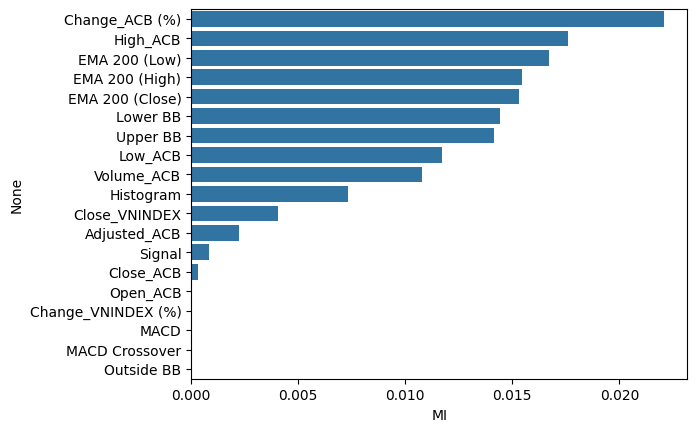

In [10]:
X = stock_data.drop(columns=["Date", "Trend"])
y = stock_data["Trend"]

mi = pd.DataFrame(data=mutual_info_classif(X, y, discrete_features=False, copy=True, random_state=42, n_jobs=-1), 
                  columns=["MI"], 
                  index=X.columns).sort_values(by=["MI"], ascending=False)
sns.barplot(data=mi, x=mi["MI"], y=mi.index)

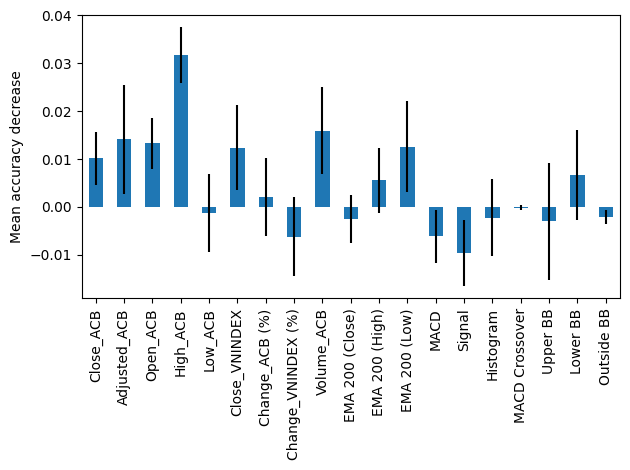

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

temp = DecisionTreeClassifier()
temp.fit(X_train, y_train)

permu_importances = permutation_importance(estimator=temp, X=X_test, y=y_test, scoring="accuracy", n_jobs=-1, random_state=42, n_repeats=200)
permu_series = pd.Series(data=permu_importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
permu_series.plot.bar(yerr=permu_importances.importances_std, ax=ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()           

In [12]:
# Remove features with MI < 0.02 AND with ~ 0 or negative mean accuracy decrease
stock_data.drop(columns=["Outside BB", "MACD Crossover", "MACD", "Change_VNINDEX (%)", "Signal", "Histogram"], inplace=True)

# Export the preprocessed data
stock_data.to_csv(path_or_buf=r"C:\Users\X1 Carbon\Desktop\preprocessed_data.csv", index=False)